In [2]:
#imports
import pandas as pd
import numpy as np
import os.path
import xarray as xr

  Using cached https://files.pythonhosted.org/packages/ab/f3/c3b45f15a82d7c89cbb6f0726d047d5d2b0ec8d1933731c125ac45a38b3d/xarray-0.11.0-py2.py3-none-any.whl
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Features 
    Blended Soil Moisture, Hour collected, Date, Month, x, y loc
### Predict
    x, y coordinates or yes/no

### Data 
    Occurence and size of wildfires - on a Date, at a Latitude and Longitude
    Soil moisture data - at x and y
    
    1. Convert Latitude and Longitude to x and y
    2. Find the date 
    3. Look for corresponding soil moisture file - 3, 2, 1, 0
    4. Get Blended, Hour features from the rows corresponding to x and y
    5. Label 0 / 1
    :)


In [3]:
# Read in Occurence dataset
# 3500000 has 03-15 onwards
df_2017 = pd.read_csv('/home/vikram/Documents/code/wildfires/new_wildfire_data/fire_archive_V1_33596.csv', skiprows=range(1, 3500000)) #2017


In [ ]:
#df_2018 = pd.read_csv('/home/vikram/Documents/code/wildfires/new_wildfire_data/fire_archive_V1_33598.csv') #2018


In [ ]:
#df_2018_nrt = pd.read_csv('/home/vikram/Documents/code/wildfires/new_wildfire_data/fire_nrt_V1_33598.csv') #2018 recent

### Display and remove any extraneous columns

In [4]:
# df_2017.head()
#Sub sampling
df_2017.shape
df_2017 = df_2017[df_2017.index % 50 == 0] 

In [5]:
#Deletes columns which are not needed
df_2017 = df_2017.drop(['acq_time', 'bright_ti4', 'scan', 'track', 'satellite', 'instrument', 'confidence', 'version', 'bright_ti5', 'frp', 'acq_time', 'type'], axis='columns')

In [6]:
df_2017.head()

,latitude,longitude,acq_date
0,17.91211,99.72757,2017-03-15
50,17.61675,99.07681,2017-03-15
100,18.23001,94.94731,2017-03-15
150,17.70353,99.37260,2017-03-15
200,17.96975,97.78020,2017-03-15


In [7]:
df_2017.shape

(329928, 3)

In [9]:
#df_2018_nrt = df_2018_nrt.drop('daynight', axis='columns')

In [ ]:
#df_2018_nrt.head()

In [ ]:
# df_all = pd.concat([df_2017, df_2018, df_2018_nrt])
#df_2018 = pd.concat([df_2018, df_2018_nrt])
# out of memory eh

In [ ]:
# rm these df_2017, df_2018, df_2018_nrt
#del(df_2018_nrt)
#df_2018.shape

### Round off Lat/long and convert to x and y coordinates

In [10]:
# Helper functions
def convLat(row):
    y = (((row['latitude'] * 1.0) + 90.0) * (720 / 180.0))
    return int(y)

def convLong(row):
    x = ((row['longitude'] + 180.0) * (1440 / 360.0))
    return int(x)

In [11]:
df_2017['x'] = df_2017.apply(convLong, axis = 1)

In [12]:
df_2017['y'] = df_2017.apply(convLat, axis = 1)

In [13]:
old_file_date = 1
temp_df = pd.DataFrame()
flag = 1
def add_soil_data(row) :
    global old_file_date
    global temp_df
    global flag
    file_date = ''.join(row['acq_date'].split('-'))
    # print(, old_file_date)
    if file_date != old_file_date:
        print("new date", file_date)
        
        # path to file with current date
        fname = '/home/vikram/Documents/code/wildfires/soil_moisture_data_1/ftp.bou.class.noaa.gov/3365939045/001/' + 'NPR_SMOPS_CMAP_D' + file_date + '.nc'
        
        #search for file with filedate and load into df
        if os.path.isfile(fname):
            print("loading data for ", file_date)
            # temp_df = pd.read_csv(fname)
            ds = xr.open_dataset(fname)
            temp_df = ds.to_dataframe()
            flag = 0
#             print(temp_df.columns)
        else:
            print("no such file")
            flag = 1
            
    old_file_date = file_date
    
    if flag == 0:
        # Get soil data for x, y
        soil_data = temp_df.query('Latitude == '+ str(row['y']) + ' and Longitude == ' + str(row['x']))
        #print("soil data query ", soil_data, soil_data.shape)
        #print("SM attr. ", str(soil_data['Blended_SM'].values))
        
        # Write combined row to file
        r = ','.join([str(row['latitude']), str(row['longitude']), str(row['y']), str(row['x']), str(row['acq_date']),
                      str(row['acq_date'].split('-')[1]), str(soil_data['Blended_hour'].values[0]), 
                      str(soil_data['Blended_SM'].values[0]), str(soil_data['NRT_SMOS_SM'].values[0]), str(soil_data['SMOS_SM'].values[0]),
                      str(soil_data['ASCAT_A_SM'].values[0]), str(soil_data['ASCAT_B_SM'].values[0]), str(soil_data['AMSR2_SM'].values[0]), 
                      str(soil_data['Spare_SM1'].values[0]), str(soil_data['Blended_QA'].values[0]), str(soil_data['NSMOS_QA'].values[0]), 
                      str(soil_data['SMOS_QA'].values[0]), str(soil_data['ASCAT_A_QA'].values[0]), str(soil_data['ASCAT_B_QA'].values[0]),
                      str(soil_data['AMSR2_QA'].values[0]), str(soil_data['Spare1_QA'].values[0]),  
                     ])
        #print(r)
        f.write(r+"\n")


In [138]:
#Calls function to open files of soil humidity data with the data from the corresponding date
# f = open('final_dataset_soil_NEW_NAME_HERE.csv','a')
f.write("latitude,longitude,y,x,acq_date,Month,Hour,Blended_SM,NRT_SMOS_SM,SMOS_SM,ASCAT_A_SM,ASCAT_B_SM,\
AMSR2_SM,Spare_SM1,Blended_QA,NSMOS_QA,SMOS_QA,ASCAT_A_QA,ASCAT_B_QA,AMSR2_QA,Spare1_QA\n")

df_2017.apply(add_soil_data, axis = 1)
f.close()

new date 20170315
loading data for  20170315
new date 20170316
loading data for  20170316
new date 20170317
loading data for  20170317
new date 20170318
loading data for  20170318
new date 20170319
loading data for  20170319
new date 20170320
loading data for  20170320
new date 20170321
loading data for  20170321
new date 20170322
loading data for  20170322
new date 20170323
loading data for  20170323
new date 20170324
loading data for  20170324
new date 20170325
loading data for  20170325
new date 20170326
loading data for  20170326
new date 20170327
loading data for  20170327
new date 20170328
loading data for  20170328
new date 20170329
loading data for  20170329
new date 20170330
loading data for  20170330
new date 20170331
loading data for  20170331
new date 20170401
loading data for  20170401
new date 20170402
loading data for  20170402
new date 20170403
loading data for  20170403
new date 20170404
loading data for  20170404
new date 20170405
loading data for  20170405
new date 2

new date 20170427
loading data for  20170427
new date 20170428
loading data for  20170428
new date 20170429
loading data for  20170429
new date 20170430
loading data for  20170430
new date 20170501
loading data for  20170501
new date 20170502
loading data for  20170502
new date 20170503
loading data for  20170503
new date 20170504
loading data for  20170504
new date 20170505
loading data for  20170505
new date 20170506
loading data for  20170506
new date 20170507
loading data for  20170507
new date 20170508
loading data for  20170508
new date 20170509
loading data for  20170509
new date 20170510
loading data for  20170510
new date 20170511
loading data for  20170511
new date 20170512
loading data for  20170512
new date 20170513
loading data for  20170513
new date 20170514
loading data for  20170514
new date 20170515
loading data for  20170515
new date 20170516
loading data for  20170516
new date 20170517
loading data for  20170517
new date 20170518
loading data for  20170518
new date 2

KeyError: ('Spare_SM1', 'occurred at index 6322650')

In [14]:
old_file_date = 1
temp_df = pd.DataFrame()
flag = 1
def add_soil_data_notfire(row) :
    global old_file_date
    global temp_df
    global flag
    
    day = row['acq_date'].split('-')[2]
    if int(day) < 5:
        return
    
    # get non wildfire data
    day = int(day) - 4
    if day < 10:
        day = "0" + str(day)
    else:
        day = str(day)
    
    actual_date = '-'.join([row['acq_date'].split('-')[0], row['acq_date'].split('-')[1], day ])
#     print(actual_date)
    
#     if ( ((df_2017['x'] == row['x']) & (df_2017['y'] == row['y']) & (df_2017['acq_date'] == actual_date)).all() ):
#         print("was a wildfire?")
#         return

    
    file_date = ''.join([row['acq_date'].split('-')[0], row['acq_date'].split('-')[1], day])
    # print(, old_file_date)
    if file_date != old_file_date:
        print("new date", file_date)
        
        # path to file with current date
        fname = '/home/vikram/Documents/code/wildfires/soil_moisture_data_1/ftp.bou.class.noaa.gov/3365939045/001/' + 'NPR_SMOPS_CMAP_D' + file_date + '.nc'
        
        #search for file with filedate and load into df
        if os.path.isfile(fname):
            print("loading data for ", file_date)
            # temp_df = pd.read_csv(fname)
            ds = xr.open_dataset(fname)
            temp_df = ds.to_dataframe()
            flag = 0
#             print(temp_df.columns)
        else:
            print("no such file")
            flag = 1
            
    old_file_date = file_date
    
    if flag == 0:
        # Get soil data for x, y
        soil_data = temp_df.query('Latitude == '+ str(row['y']) + ' and Longitude == ' + str(row['x']))
        #print("soil data query ", soil_data, soil_data.shape)
        #print("SM attr. ", str(soil_data['Blended_SM'].values))
        
        # Write combined row to file
        r = ','.join([str(row['latitude']), str(row['longitude']), str(row['y']), str(row['x']), actual_date,
                      str(row['acq_date'].split('-')[1]), str(soil_data['Blended_hour'].values[0]), 
                      str(soil_data['Blended_SM'].values[0]), str(soil_data['NRT_SMOS_SM'].values[0]), str(soil_data['SMOS_SM'].values[0]),
                      str(soil_data['ASCAT_A_SM'].values[0]), str(soil_data['ASCAT_B_SM'].values[0]), str(soil_data['AMSR2_SM'].values[0]), 
                      str(soil_data['Spare_SM1'].values[0]), str(soil_data['Blended_QA'].values[0]), str(soil_data['NSMOS_QA'].values[0]), 
                      str(soil_data['SMOS_QA'].values[0]), str(soil_data['ASCAT_A_QA'].values[0]), str(soil_data['ASCAT_B_QA'].values[0]),
                      str(soil_data['AMSR2_QA'].values[0]), str(soil_data['Spare1_QA'].values[0]),  
                     ])
        #print(r)
        f.write(r+"\n")


In [175]:
f = open('final_dataset_soil_notfire_7_4_NEWNAME.csv','a')
f.write("latitude,longitude,y,x,acq_date,Month,Hour,Blended_SM,NRT_SMOS_SM,SMOS_SM,ASCAT_A_SM,ASCAT_B_SM,\
AMSR2_SM,Spare_SM1,Blended_QA,NSMOS_QA,SMOS_QA,ASCAT_A_QA,ASCAT_B_QA,AMSR2_QA,Spare1_QA\n")
df_2017.apply(add_soil_data_notfire, axis = 1)
f.close()

new date 20170311
no such file
new date 20170312
no such file
new date 20170313
no such file
new date 20170314
no such file
new date 20170315
loading data for  20170315
new date 20170316
loading data for  20170316
new date 20170317
loading data for  20170317
new date 20170318
loading data for  20170318
new date 20170319
loading data for  20170319
new date 20170320
loading data for  20170320
new date 20170321
loading data for  20170321
new date 20170322
loading data for  20170322
new date 20170323
loading data for  20170323
new date 20170324
loading data for  20170324
new date 20170325
loading data for  20170325
new date 20170326
loading data for  20170326
new date 20170327
loading data for  20170327
new date 20170401
loading data for  20170401
new date 20170402
loading data for  20170402
new date 20170403
loading data for  20170403
new date 20170404
loading data for  20170404
new date 20170405
loading data for  20170405
new date 20170406
loading data for  20170406
new date 20170407
loa

new date 20170519
loading data for  20170519
new date 20170520
loading data for  20170520
new date 20170521
loading data for  20170521
new date 20170522
loading data for  20170522
new date 20170523
loading data for  20170523
new date 20170524
loading data for  20170524
new date 20170525
loading data for  20170525
new date 20170526
loading data for  20170526
new date 20170527
loading data for  20170527
new date 20170601
loading data for  20170601
new date 20170602
loading data for  20170602
new date 20170603
loading data for  20170603
new date 20170604
loading data for  20170604


KeyboardInterrupt: 

### Read in final datasets (from March to August, 2017)

In [15]:
df_y = pd.read_csv('/home/vikram/Documents/code/wildfires/final_dataset_soil.csv') # Yes
df_y['wildfire'] = 1
df_y.head()

/home/vikram/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,latitude,longitude,y,x,acq_date,Month,Hour,Blended_SM,NRT_SMOS_SM,SMOS_SM,...,AMSR2_SM,Spare_SM1,Blended_QA,NSMOS_QA,SMOS_QA,ASCAT_A_QA,ASCAT_B_QA,AMSR2_QA,Spare1_QA,wildfire
0,17.9121,99.7276,431,1118,2017-03-15,3,-99,-0.0999,-0.0999,-0.0999,...,-0.0999,-999,-999,-999,-999,-999,-999,-999,-999,1
1,17.6167,99.0768,430,1116,2017-03-15,3,-99,-0.0999,-0.0999,-0.0999,...,-0.0999,-999,-999,-999,-999,-999,-999,-999,-999,1
2,18.23,94.9473,432,1099,2017-03-15,3,-99,-0.0999,-0.0999,-0.0999,...,-0.0999,-999,-999,-999,-999,-999,-999,-999,-999,1
3,17.7035,99.3726,430,1117,2017-03-15,3,-99,-0.0999,-0.0999,-0.0999,...,-0.0999,-999,-999,-999,-999,-999,-999,-999,-999,1
4,17.9698,97.7802,431,1111,2017-03-15,3,-99,-0.0999,-0.0999,-0.0999,...,-0.0999,-999,-999,-999,-999,-999,-999,-999,-999,1


In [16]:
df_y = df_y.drop_duplicates(['acq_date', 'y', 'x'])


In [17]:
df_y.shape
# df_y.to_csv("/home/vikram/Documents/code/wildfires/final_dataset_soil_positives.csv")

(136992, 22)

In [18]:
df_no = pd.read_csv('/home/vikram/Documents/code/wildfires/final_dataset_soil_notfire_7_4_NEWNAME.csv') # No
df_no['wildfire'] = 0
df_no.head(n=50)

,latitude,longitude,y,x,acq_date,Month,Hour,Blended_SM,NRT_SMOS_SM,SMOS_SM,...,AMSR2_SM,Spare_SM1,Blended_QA,NSMOS_QA,SMOS_QA,ASCAT_A_QA,ASCAT_B_QA,AMSR2_QA,Spare1_QA,wildfire
0,-26.67043,27.81133,253,831,2017-03-15,3,7,0.0603,-0.0999,-0.0999,...,-0.0999,-999,517,-999,-999,-999,517,-999,-999,0
1,-25.61900,27.21839,257,828,2017-03-15,3,8,0.0432,-0.0999,-0.0999,...,-0.0999,-999,5,-999,-999,5,4,-999,-999,0
2,-0.09303,36.19989,359,864,2017-03-15,3,15,0.1327,0.0408,-0.0999,...,-0.0999,-999,1,1,-999,3847,4615,-999,-999,0
3,6.39946,33.11708,385,852,2017-03-15,3,15,0.2467,0.2197,-0.0999,...,0.1647,-999,1,1,-999,263,519,-22754,-999,0
4,6.11233,39.73030,384,878,2017-03-15,3,-99,-0.0999,-0.0999,-0.0999,...,-0.0999,-999,-999,-999,-999,-999,-999,-999,-999,0
5,8.28257,30.03525,393,840,2017-03-15,3,11,0.1247,-0.0999,-0.0999,...,0.1472,-999,-17511,-999,-999,519,-999,-17511,-999,0
6,8.06470,34.03362,392,856,2017-03-15,3,15,0.2870,0.2276,-0.0999,...,0.1597,-999,1,1,-999,1289,777,-30619,-999,0
7,8.75848,30.80748,395,843,2017-03-15,3,-99,-0.0999,-0.0999,-0.0999,...,-0.0999,-999,-999,-999,-999,1291,6919,-999,-999,0
8,-12.07683,26.39292,311,825,2017-03-15,3,-99,-0.0999,-0.0999,-0.0999,...,-0.0999,-999,-999,-999,-999,6,6,-999,-999,0
9,8.87998,30.72514,395,842,2017-03-15,3,11,0.1007,-0.0999,-0.0999,...,0.1315,-999,-22545,-999,-999,2825,2058,-22545,-999,0


In [19]:
df_no.duplicated(['acq_date', 'y', 'x']).count()
df_no = df_no.drop_duplicates(['acq_date', 'y', 'x'])


In [20]:
df_no.shape

(92816, 22)

In [21]:
df_comb = pd.concat([df_y, df_no])

In [22]:
print("Yes ", df_y.shape, "\nNo ", df_no.shape, "\nCombined ", df_comb.shape)

Yes  (136992, 22) 
No  (92816, 22) 
Combined  (229808, 22)


In [23]:
#without duplicates
df_final = df_comb.drop_duplicates(['acq_date', 'y', 'x'])

# Find duplicates
# df_dups= df_comb.duplicated(['acq_date', 'y', 'x'])

In [24]:
df_final.shape

(218985, 22)

In [25]:
# Check imbalance
df_final['wildfire'].value_counts()

1    136992
0     81993
Name: wildfire, dtype: int64

In [26]:
# Convert invalid fill values to NaNs
df_final = df_final.replace(-999, np.nan)
df_final = df_final.replace(-0.0999, np.nan)
df_final = df_final.replace(-99, np.nan)
df_final = df_final.replace(-999, np.nan)
df_final = df_final.replace(-999, np.nan)


In [27]:
df_final.head()

,latitude,longitude,y,x,acq_date,Month,Hour,Blended_SM,NRT_SMOS_SM,SMOS_SM,...,AMSR2_SM,Spare_SM1,Blended_QA,NSMOS_QA,SMOS_QA,ASCAT_A_QA,ASCAT_B_QA,AMSR2_QA,Spare1_QA,wildfire
0,17.9121,99.7276,431,1118,2017-03-15,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,17.6167,99.0768,430,1116,2017-03-15,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,18.23,94.9473,432,1099,2017-03-15,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,17.7035,99.3726,430,1117,2017-03-15,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,17.9698,97.7802,431,1111,2017-03-15,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [28]:
# Impute with means
# df_final.fillna(df_final.mean(), inplace=True)


In [29]:
df_final.head()

,latitude,longitude,y,x,acq_date,Month,Hour,Blended_SM,NRT_SMOS_SM,SMOS_SM,...,AMSR2_SM,Spare_SM1,Blended_QA,NSMOS_QA,SMOS_QA,ASCAT_A_QA,ASCAT_B_QA,AMSR2_QA,Spare1_QA,wildfire
0,17.9121,99.7276,431,1118,2017-03-15,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,17.6167,99.0768,430,1116,2017-03-15,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,18.23,94.9473,432,1099,2017-03-15,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,17.7035,99.3726,430,1117,2017-03-15,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,17.9698,97.7802,431,1111,2017-03-15,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [30]:
import pylab
import matplotlib.pyplot as plt
def plot_corr(df,size=10):
    corr = df.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Oranges)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    pylab.savefig('matrix.png')
plot_corr(df_final)

In [31]:
print(df_final.isna().sum())

latitude            0
longitude           0
y                   0
x                   0
acq_date            0
Month               0
Hour           120092
Blended_SM     120967
NRT_SMOS_SM    160139
SMOS_SM        160114
ASCAT_A_SM     148001
ASCAT_B_SM     147171
AMSR2_SM       142550
Spare_SM1      190958
Blended_QA     119359
NSMOS_QA       158946
SMOS_QA        158870
ASCAT_A_QA     146920
ASCAT_B_QA     146085
AMSR2_QA       141581
Spare1_QA      189378
wildfire            0
dtype: int64


In [42]:
df_final_less = df_final.iloc[:, np.r_[2,3,5,6,11,12, 18, 21]]

#Chosen from correlation matrix
# df_final_less = df_final.iloc[:, np.r_[2,3,5,6,7,11,12,17,18:22]]
# df_final_less = df_final.iloc[:, np.r_[2,3,5,6,12,17,19:22]]

# df_final_less = df_final.iloc[:, np.r_[2,3, 5:13, 14:22]]


#SM and ASCAT
# df_final_less = df_final.iloc[:, np.r_[2,3,5,6,7,10,17,14,21]]

In [43]:
df_final_less = df_final_less.dropna()

In [44]:
df_final_less.shape

(53723, 8)

In [45]:
df_final_less.columns

Index(['y', 'x', 'Month', 'Hour', 'ASCAT_B_SM', 'AMSR2_SM', 'ASCAT_B_QA',
       'wildfire'],
      dtype='object')

## Create decision tree

### Test and train split (stratified)

In [46]:
from sklearn.model_selection import train_test_split  

In [47]:
df_final_less.columns
# df_final.columns

Index(['y', 'x', 'Month', 'Hour', 'ASCAT_B_SM', 'AMSR2_SM', 'ASCAT_B_QA',
       'wildfire'],
      dtype='object')

In [48]:
# x and y 
# X = df_final.iloc[:, np.r_[2,3,5:20]]
# y = df_final.iloc[:, 21]

# Blended set
X = df_final_less.iloc[:, np.r_[0:8]]
y = df_final_less.iloc[:, 8]

# #Blended + ASCAT set
# X = df_final_less.iloc[:, np.r_[0:11]]
# y = df_final_less.iloc[:, 11]


IndexError: single positional indexer is out-of-bounds

In [39]:
print("x ", X.shape, " y ", y.shape)


x  (53723, 8)  y  (53723,)


### PCA on feature set

In [40]:
from sklearn.preprocessing import StandardScaler

# Normalize data
X = StandardScaler().fit_transform(X)

ValueError: could not convert string to float: 'AMSR2_QA'

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

ValueError: could not convert string to float: 'AMSR2_QA'

In [257]:
print( principalDf.shape, y.shape, type(principalDf) , type(y))

(26507, 2) (53723,) <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [258]:
principalDf.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
# df = pd.concat([df1, df2], axis=1)
pca_df = pd.concat([principalDf, y], axis = 1)

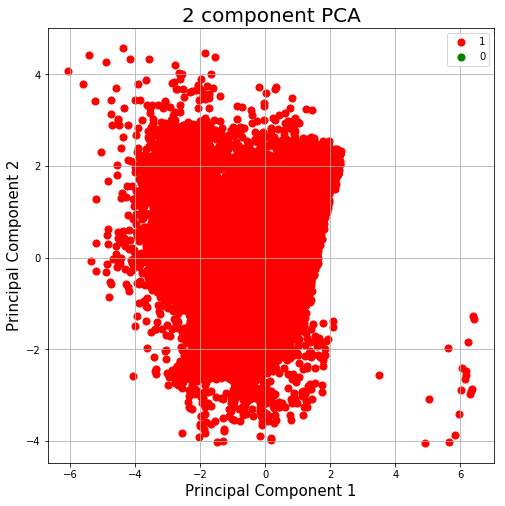

In [259]:
import matplotlib.pyplot as plt

#plot
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(y.unique(),colors):
    indicesToKeep = y == target
    ax.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(y.unique())
pylab.savefig('pca.png')
ax.grid()

In [260]:
pca.explained_variance_ratio_

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

In [261]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: wildfire, dtype: int64

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state = 42)  

In [264]:
X_train.iloc[0]

y                337
x                825
Month              6
Hour              23
ASCAT_B_SM     0.744
AMSR2_SM      0.0453
ASCAT_B_QA        13
AMSR2_QA      -29570
Name: 81124, dtype: object

### Training decision tree model

In [265]:
from sklearn.tree import DecisionTreeClassifier  
classifier = DecisionTreeClassifier()  
classifier.fit(X_train, y_train)

ValueError: could not convert string to float: 'y'

### Testing accuracy of decision tree model

In [79]:
y_pred = classifier.predict(X_test)  #Predicting results for test split

In [80]:
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import accuracy_score
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

[[1052 1298]
 [1329 1623]]
              precision    recall  f1-score   support

           0       0.44      0.45      0.44      2350
           1       0.56      0.55      0.55      2952

   micro avg       0.50      0.50      0.50      5302
   macro avg       0.50      0.50      0.50      5302
weighted avg       0.51      0.50      0.50      5302

Accuracy:  0.504526593738212


array([[-0.47625922, -0.07198702,  0.22115737, ..., -0.8650168 ,
        -0.40730839, -0.27852415],
       [ 3.75438058,  3.19864177, -0.55344867, ..., -0.87264963,
        -0.40655874, -0.96710396],
       [-0.47625922, -0.07998367,  0.99576342, ..., -0.81769329,
         0.16991877,  1.30521488],
       ...,
       [-3.07174376,  3.06269877, -2.10266075, ...,  0.22037094,
        -0.40655874, -0.47935765],
       [-0.47625922,  0.14392246,  0.99576342, ..., -0.47574276,
        -0.21090123, -0.21542851],
       [-0.65794314, -0.08798032,  0.22115737, ..., -0.62381954,
        -0.40730839,  1.44289801]])

### Clustering

In [84]:
from sklearn.cluster import KMeans  

In [102]:
kmeans = KMeans(n_clusters=2)  
kmeans.fit(X_train)  

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [103]:
print(kmeans.cluster_centers_)  

[[-0.39444341  0.07512048  0.36275101 -0.05203202  0.06513444 -0.32780043
  -0.12133584 -0.0164914 ]
 [ 1.30899839 -0.29245042 -1.20321498  0.17758636 -0.22759147  1.08774912
   0.39795951  0.05059873]]


In [104]:
df_final_less.columns

Index(['y', 'x', 'Month', 'Hour', 'ASCAT_B_SM', 'AMSR2_SM', 'ASCAT_B_QA',
       'AMSR2_QA', 'wildfire'],
      dtype='object')

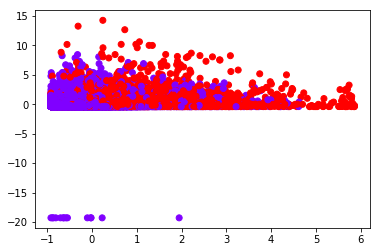

In [105]:
plt.scatter(X_train[:,5],X_train[:,6], c=kmeans.labels_, cmap='rainbow')  

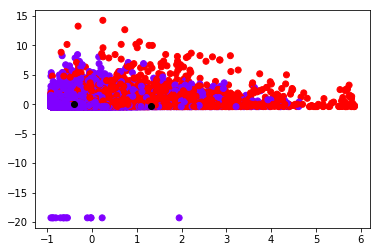

In [107]:
plt.scatter(X_train[:,5], X_train[:,6], c=kmeans.labels_, cmap='rainbow')  
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')  


### SVMs

#### Polynomial kernel

In [42]:
from sklearn.svm import SVC  
# svclassifier = SVC(kernel='linear')  
svclassifier = SVC(kernel='poly')  

svclassifier.fit(X_train, y_train)  

/home/vikram/.virtualenvs/pw/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [43]:
y_pred = svclassifier.predict(X_test)  

In [46]:
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print("Accuracy: ", accuracy_score(y_test, y_pred))

[[   1 2349]
 [   2 2950]]
              precision    recall  f1-score   support

           0       0.33      0.00      0.00      2350
           1       0.56      1.00      0.72      2952

   micro avg       0.56      0.56      0.56      5302
   macro avg       0.45      0.50      0.36      5302
weighted avg       0.46      0.56      0.40      5302

Accuracy:  0.5565824217276499


#### Gaussian kernel 

In [114]:
from sklearn.svm import SVC  
# svclassifier = SVC(kernel='linear')  
svclassifier = SVC(kernel='rbf')  

svclassifier.fit(X_train, y_train)  



/home/vikram/.virtualenvs/pw/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [115]:
y_pred = svclassifier.predict(X_test)  


In [116]:
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print("Accuracy: ", accuracy_score(y_test, y_pred))

[[  50 2300]
 [  54 2898]]
              precision    recall  f1-score   support

           0       0.48      0.02      0.04      2350
           1       0.56      0.98      0.71      2952

   micro avg       0.56      0.56      0.56      5302
   macro avg       0.52      0.50      0.38      5302
weighted avg       0.52      0.56      0.41      5302

Accuracy:  0.5560165975103735
